In [1]:
import helpers
import cv2
import data_module
from cv2 import Mat
import numpy as np
from enums import EnvironmentType


In [2]:
from skimage.metrics import structural_similarity as ssim

def get_metrics(src_image: Mat, composition_image: Mat, overlap_mask: Mat):
    contours, _ = cv2.findContours(cv2.cvtColor(overlap_mask, cv2.COLOR_RGB2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mainContour = contours[0]
    o_x, o_y, o_w, o_h = cv2.boundingRect(mainContour)

    result_overlap = cv2.copyTo(composition_image.astype(np.uint8), overlap_mask)[o_y:o_y+o_h, o_x:o_x+o_w]
    src_overlap = cv2.copyTo(src_image, overlap_mask)[o_y:o_y+o_h, o_x:o_x+o_w]

    helpers.show_image(overlap_mask)
    helpers.show_image_pair(src_overlap, result_overlap)

    print(result_overlap.shape, src_overlap.shape)

    ssim_score = ssim(src_overlap, result_overlap, channel_axis=-1)
    mse = np.mean((src_overlap - result_overlap) ** 2)
    psnr = cv2.PSNR(src_overlap, result_overlap)

    return ssim_score, mse, psnr

    


.\datasets\isiqa_release\stitched_data\16\2.jpg
.\datasets\isiqa_release\stitched_data\16\3.jpg
(567, 1008, 3)
(567, 1008, 3)
(416, 640, 3)
(416, 640, 3)


c:\Users\pavlo.butenko\university\bachelor\proj\image_stitching\SIFT\helpers.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


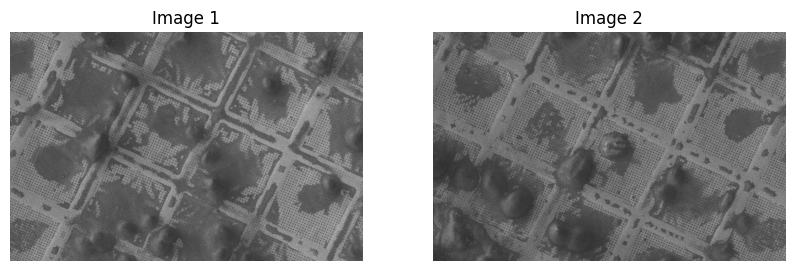

In [2]:
# dm = data_module.UDISDataModule(r'.\datasets\UDIS\testing')
dm = data_module.ISIQADataModule(r'.\datasets\isiqa_release\stitched_data')

img1, img2 = dm.get_random_pair()

print(img1.shape)
print(img2.shape)


# print(414 % 32)


img1 = cv2.imread(r"C:\Users\pavlo.butenko\Downloads\ElectronTile7.png")
img2 = cv2.imread(r"C:\Users\pavlo.butenko\Downloads\ElectronTile6.png")

img1 = cv2.resize(img1, (640, 416))
img2 = cv2.resize(img2, (640, 416))

print(img1.shape)
print(img2.shape)

helpers.show_image_pair(img1, img2)

In [3]:
h, w = img1.shape[:2]
w_difference = w / 640
p_height = int(h / w_difference)
modulo = p_height % 32

if modulo > 32 / 2:
    modulo -= 32

new_height = p_height - modulo
h_difference = h / new_height

In [12]:
print(new_height)

352


In [6]:
from match_finders import AdaMatcherMatchFinder, FeatureDetector, FeatureDetectorMatchFinder, LoFTRMatchFinder


k1, k2 = AdaMatcherMatchFinder().find_matches(img1, img2) 
k1_copy = k1.copy()

k1 = k1[(k1[:, 0] < 0.05 * w) & (k2[:, 0] > 0.95 * w)]
print(k1)
k2 = k2[(k1_copy[:, 0] < 0.05 * w) & (k2[:, 0] > 0.95 * w)]

# k2 = k2[k2[:, 0] < 0.2 * w]





: 

float64
[< cv2.DMatch 000001D58CF42430>, < cv2.DMatch 000001D58CF414D0>, < cv2.DMatch 000001D58CF41230>, < cv2.DMatch 000001D58CF42DD0>, < cv2.DMatch 000001D58CF43470>, < cv2.DMatch 000001D58CF41070>, < cv2.DMatch 000001D58CF43930>, < cv2.DMatch 000001D58CF40530>, < cv2.DMatch 000001D58CF405B0>, < cv2.DMatch 000001D58CF43550>, < cv2.DMatch 000001D58CF43B70>, < cv2.DMatch 000001D58CF42E70>, < cv2.DMatch 000001D58CF42F30>, < cv2.DMatch 000001D58CF42AF0>, < cv2.DMatch 000001D58CF40310>, < cv2.DMatch 000001D58CF42290>, < cv2.DMatch 000001D58CF423B0>, < cv2.DMatch 000001D58CF42190>, < cv2.DMatch 000001D58CF436B0>, < cv2.DMatch 000001D58CF42370>, < cv2.DMatch 000001D58CF42590>, < cv2.DMatch 000001D58CF42B90>, < cv2.DMatch 000001D58CF40490>, < cv2.DMatch 000001D58CF402F0>, < cv2.DMatch 000001D58CF41BD0>, < cv2.DMatch 000001D58CF40D70>, < cv2.DMatch 000001D58CF43A30>, < cv2.DMatch 000001D58CF41FD0>, < cv2.DMatch 000001D58CF424F0>, < cv2.DMatch 000001D58CF42F70>, < cv2.DMatch 000001D58CF421B0>,

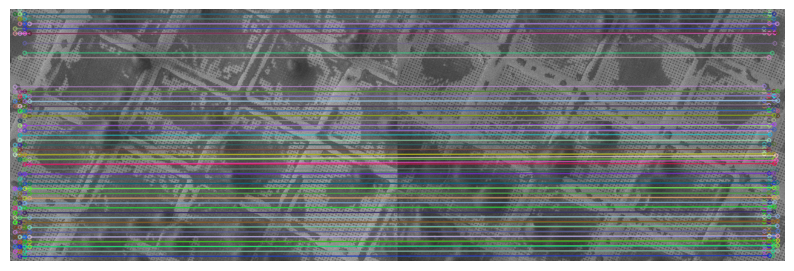

In [123]:
from composition_module import ComplexAlphaCompositionModule, UdisCompositionModule
from warp_module import SingleWarpModule


matches = []

print(k1.dtype)

kk1 = list(map(lambda x: cv2.KeyPoint(x[0], x[1], 0), k1))
kk2 = list(map(lambda x: cv2.KeyPoint(x[0], x[1], 0), k2))

for i in range(len(k1)):
    match = cv2.DMatch(_queryIdx=i, _trainIdx=i, _imgIdx=0, _distance=0.0)
    matches.append(match)

print(matches)

helpers.show_image(cv2.drawMatches(img1, kk1, img2, kk2, matches, None))

warper = SingleWarpModule()

src, dst, mask1, mask2 = warper.warp_images(img1, img2, k1, k2)
result = UdisCompositionModule().composite(src, mask1, dst, mask2)


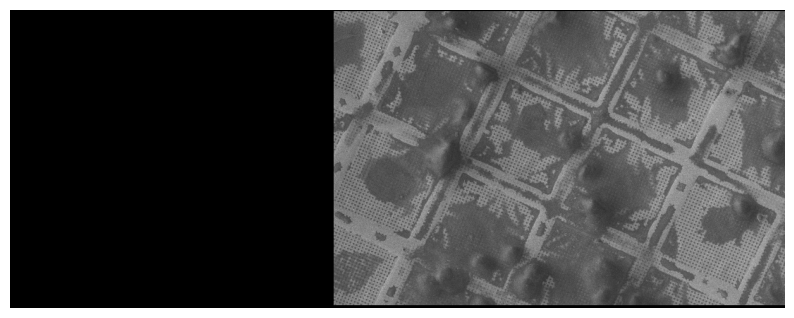

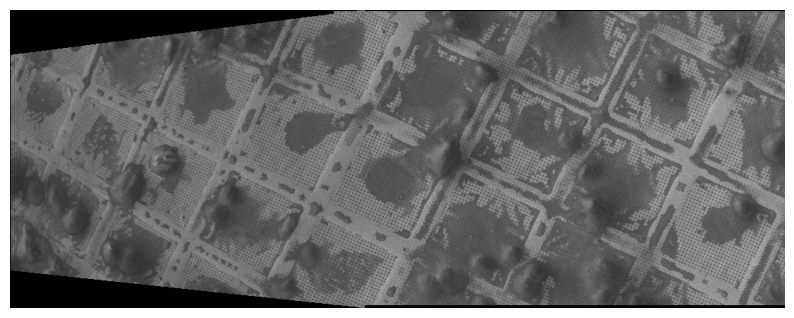

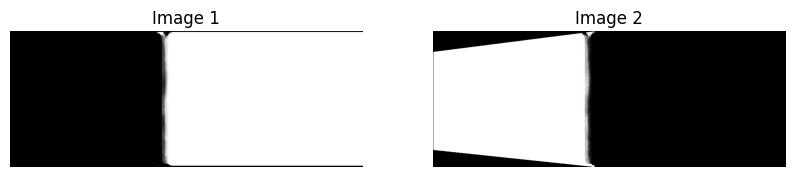

In [124]:
helpers.show_image(src)
helpers.show_image(result[0].astype(np.uint8))
helpers.show_image_pair(result[1].astype(np.uint8), result[2].astype(np.uint8))

In [3]:
from image_stitcher import ComposerType, DetectorType, ImageStitcher
stitcher1 = ImageStitcher(DetectorType.SIFT, ComposerType.ComplexAlpha, EnvironmentType.Indoor)
stitcher2 = ImageStitcher(DetectorType.AdaMatcher, ComposerType.ComplexAlpha, EnvironmentType.Indoor)

c:\Users\pavlo.butenko\university\bachelor\proj\image_stitching\SIFT\helpers.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


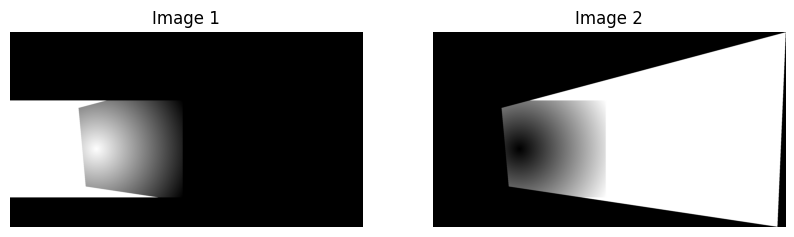

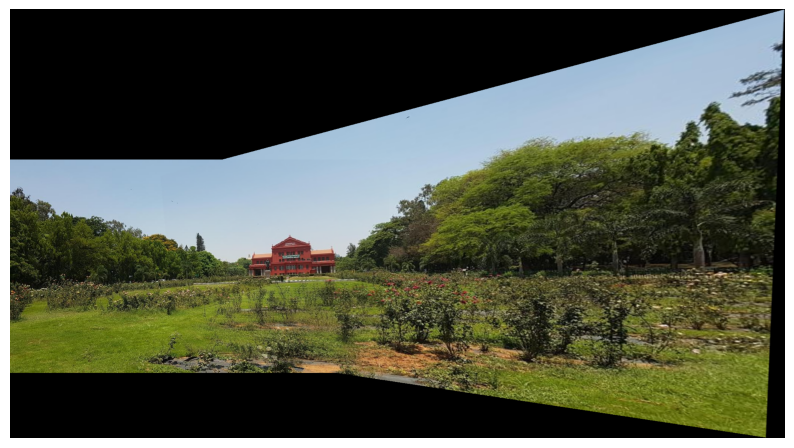

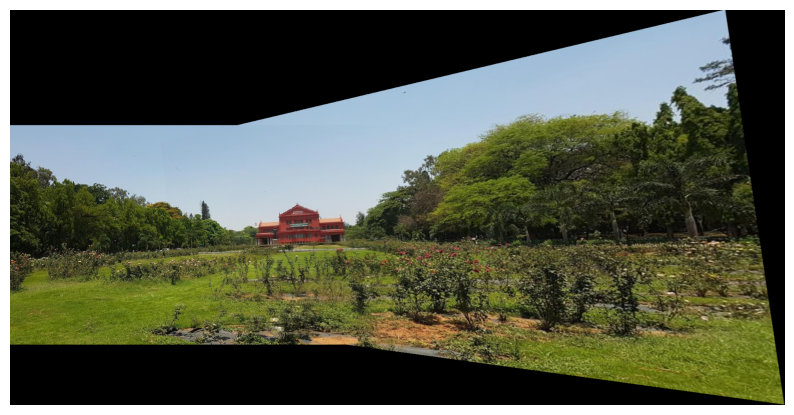

In [4]:
result, m1, m2 = stitcher1.stitch(img1, img2)
result2, _, _ = stitcher2.stitch(img1, img2)

helpers.show_image_pair(m1.astype(np.uint8), m2.astype(np.uint8))
helpers.show_image(result.astype(np.uint8))
helpers.show_image(result2.astype(np.uint8))

In [ ]:
(m1 / 255) * src

In [ ]:
from composition_module import AlphaCompositionModule, SimpleCompositionModule, UdisCompositionModule
from match_finders import LoFTRMatchFinder, LoFTRType, MatchFinder
from warp_module import SingleWarpModule


matcher = LoFTRMatchFinder(LoFTRType.Indoor, r'.\tools\LoFTR\weights\indoor_ds_new.ckpt')

keypoint1, keypoint2 = matcher.find_matches(img1, img2)
wrapper = SingleWarpModule()
src, dst, mask1, mask2 = wrapper.warp_images(img1, img2, keypoint1, keypoint2)



helpers.show_image_pair(src.astype(np.uint8), dst.astype(np.uint8))
composition = SimpleCompositionModule()
ucomposition = UdisCompositionModule()
result, m1, m2 = composition.composite(src, mask1, dst, mask2)
result2, m1, m2 = ucomposition.composite(src, mask1, dst, mask2)
helpers.show_image_pair(m1.astype(np.uint8), m2.astype(np.uint8))

helpers.show_image(result.astype(np.uint8))
helpers.show_image(result2.astype(np.uint8))

In [ ]:
from warp_composer import DetectorFreeModel, DetectorFreeWarper
from match_finders import LoFTRType
from composition_module import UdisCompositionModule



warper = DetectorFreeWarper(DetectorFreeModel.LoFTR, LoFTRType.Outdoor)
composer = UdisCompositionModule()

warp1, warp2, mask1, mask2 = warper.construct_warp(img1, img2)
result, _, _ = composer.composite(warp1, mask1, warp2, mask2)

helpers.show_image(result.astype(np.uint8))




In [ ]:
cv2.findContours(mask1, cv2.EXTERNAL, )

In [ ]:
from composition_module import AlphaCompositionModule, SimpleCompositionModule, UdisCompositionModule
from match_finders import AdaMatcherMatchFinder, LoFTRType, MatchFinder
from warp_module import SingleWarpModule


matcher = AdaMatcherMatchFinder()

keypoint1, keypoint2 = matcher.find_matches(img1, img2)

wrapper = SingleWarpModule()
src, dst, mask1, mask2 = wrapper.warp_images(img1, img2, keypoint1, keypoint2)

helpers.show_image_pair(src.astype(np.uint8), dst.astype(np.uint8))
composition = SimpleCompositionModule()
ucomposition = UdisCompositionModule()
result, m1, m2 = composition.composite(src, mask1, dst, mask2)
result2, m1, m2 = ucomposition.composite(src, mask1, dst, mask2)
helpers.show_image_pair(m1.astype(np.uint8), m2.astype(np.uint8))

helpers.show_image(result.astype(np.uint8))
helpers.show_image(result2.astype(np.uint8))

In [ ]:
print(np.unique(result[0]["mkpts0_f"].astype(np.int32), axis=0).shape) 

print(np.unique(result[0]["mkpts0_f"].astype(np.int32), axis=0).shape)
arr = result[0]["mkpts1_f"].astype(np.int32)
print(np.unique(result[0]["mkpts1_f"].astype(np.int32), axis=0).shape)

# Get unique points and their counts
unique_points, counts = np.unique(result[0]["mkpts1_f"].astype(np.int32), axis=0, return_counts=True)

# Select points that appear more than once (duplicates)
duplicates = unique_points[counts > 1]

# Get indices of duplicate elements
# duplicate_indices = {tuple(dup): np.where((arr == dup).all(axis=0))[0] for dup in duplicates}
indices = np.where(np.any(np.all(arr[:, None] == duplicates, axis=2), axis=1))[0]

print(indices)

for index in indices:
    print(result[0]["mkpts0_f"][index], result[0]["mkpts1_f"][index])

load model from ./tools/UDIS2/Warp/model\epoch100_model.pth!
tensor(617.3882, device='cuda:0')
tensor(532.3553, device='cuda:0')
torch.Size([1, 3, 532, 617])
(532, 617, 3)
load model from ./tools/UDIS2/Composition/model\epoch050_model.pth!
(532, 617, 3)
1
0 1 512 512
255.0


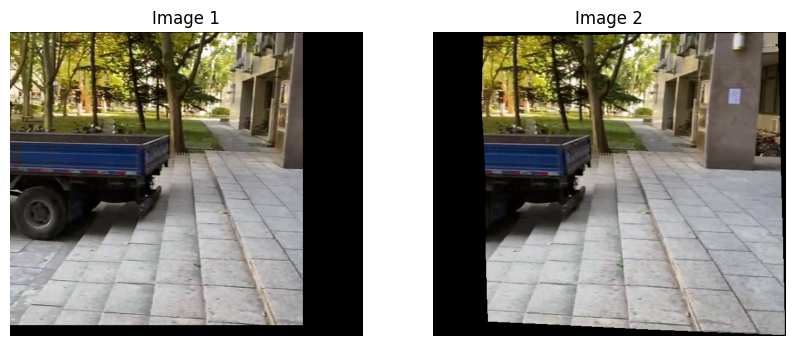

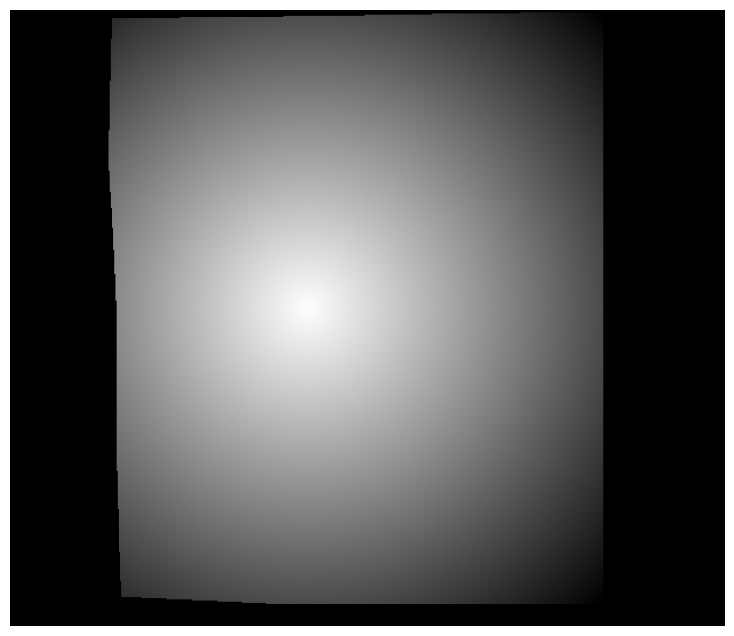

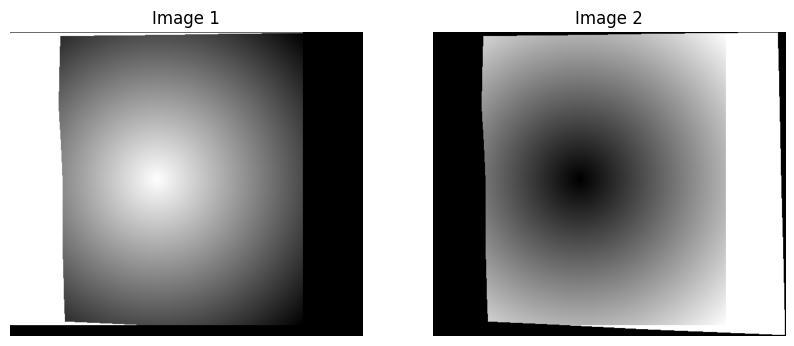

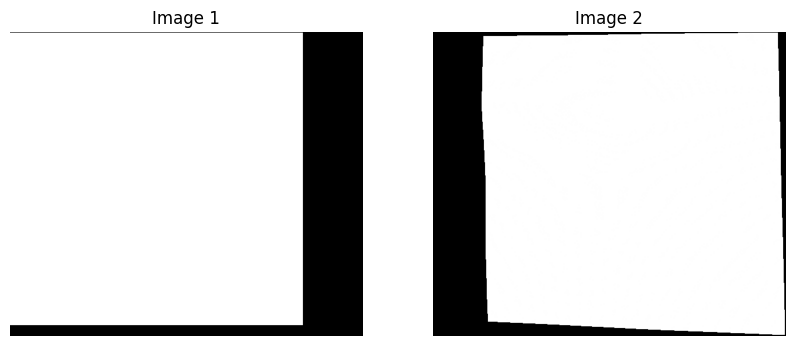

In [15]:


import helpers
from warp_composer import UDIS2WarpConstructor
from composition_module import ComplexAlphaCompositionModule, UdisCompositionModule
import numpy as np


composer = UDIS2WarpConstructor()
warp1, warp2, mask1, mask2 = composer.construct_warp(img1, img2)
print(warp1.shape)
helpers.show_image_pair(warp1.astype(np.uint8), warp2.astype(np.uint8))

ucomposition = UdisCompositionModule()
# result, m1, m2 = composition.composite(src, mask1, dst, mask2)
result2, m1, m2 = ucomposition.composite(warp1, mask1, warp2, mask2)

ccomposition = ComplexAlphaCompositionModule()
print(mask1.shape)
result1, m1, m2 = ccomposition.composite(warp1, mask1, warp2, mask2)

# helpers.show_image(src.astype(np.uint8))

helpers.show_image_pair(m1.astype(np.uint8), m2.astype(np.uint8))
helpers.show_image_pair(mask1.astype(np.uint8), mask2.astype(np.uint8))

(532, 617, 3)
255.0
(532, 617, 3)


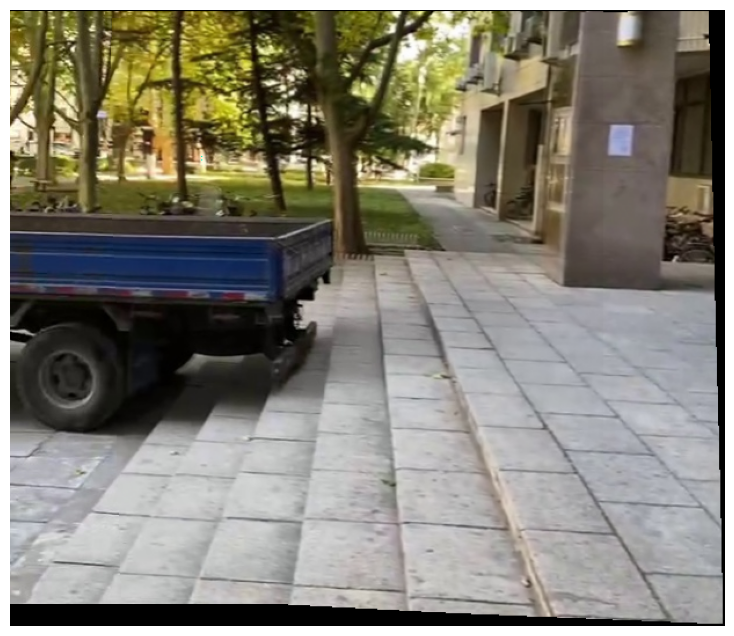

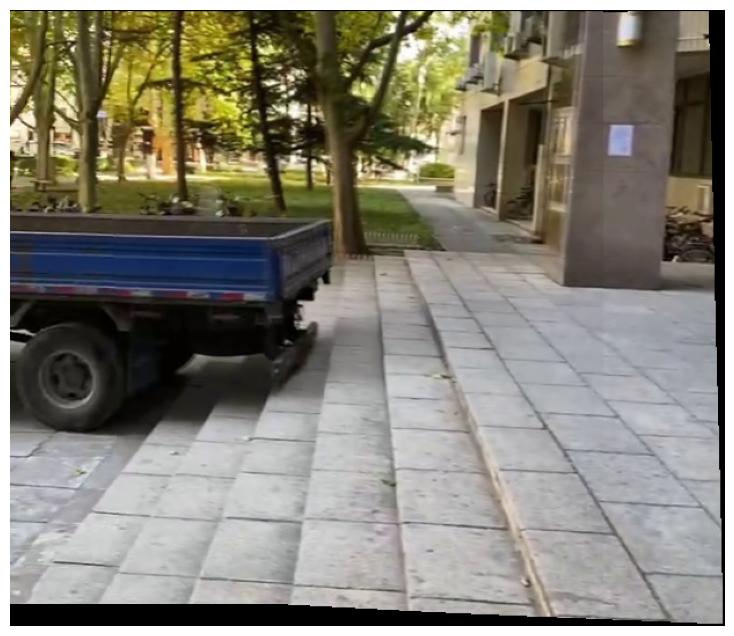

In [18]:
from composition_module import AlphaCompositionModule

helpers.show_image(result1.astype(np.uint8))
print(mask1.shape)
print(np.max(mask1))

ccomposition = AlphaCompositionModule()
print(mask1.shape)
result1, m1, m2 = ccomposition.composite(warp1, mask1, warp2, mask2)

helpers.show_image(result1.astype(np.uint8))


In [ ]:


x, y = np.meshgrid(np.arange(512), np.arange(512))
dist = np.sqrt((x - 512/2)**2 + (y - 512/2)**2)
max_dist = np.sqrt((512/2)**2 + (512/2)**2)  # Maximum distance from center
alpha_mask = (1 - dist / max_dist) * 255

helpers.show_image(alpha_mask.astype(np.uint8))

In [ ]:
from match_finders import FeatureDetector, FeatureDetectorMatchFinder, Matcher
from composition_module import AlphaCompositionModule, SimpleCompositionModule, UdisCompositionModule
from match_finders import LoFTRMatchFinder, LoFTRType, MatchFinder
from warp_module import SingleWrapModule


matcher2 = FeatureDetectorMatchFinder(FeatureDetector.SIFT, Matcher.FLANN)

keypoint1, keypoint2 = matcher2.find_matches(img1, img2)
wrapper = SingleWrapModule()
src, dst, mask1, mask2 = wrapper.warp_images(img1, img2, keypoint1, keypoint2)
helpers.show_image_pair(src.astype(np.uint8), dst.astype(np.uint8))
helpers.show_image_pair(mask1.astype(np.uint8), mask2.astype(np.uint8))
composition = SimpleCompositionModule()
ucomposition = UdisCompositionModule()
result, m1, m2 = composition.composite(src, mask1, dst, mask2)
helpers.show_image(dst.astype(np.uint8))
helpers.show_image_pair(m1.astype(np.uint8), m2.astype(np.uint8))
result2, m1, m2 = ucomposition.composite(src, mask1, dst, mask2)
helpers.show_image_pair(m1.astype(np.uint8), m2.astype(np.uint8))

helpers.show_image(result.astype(np.uint8))
helpers.show_image(result2.astype(np.uint8))

ssim_score, mse, psnr = get_metrics(src, result2, cv2.bitwise_and(mask1, mask2))

print('Ssim: ', ssim_score)
print('Msr: ', mse)
print('PSNR: ', psnr)

In [ ]:
H, mask = cv2.findHomography(keypoint2, keypoint1, cv2.RANSAC, 5.0)

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
dst = cv2.warpPerspective(img2, H, ((w1 + w2), h1))
# dst*=0

edgeCenter = (img1.shape[1] // 2, (img1.shape[0] // 2))
print(edgeCenter, dst.shape)
mask = 255 * np.ones(img1.shape, img1.dtype)
# padding = 0
# mask = 255 * cv2.rectangle(mask, (0, padding), (img1.shape[1], img1.shape[0] - padding), (1, 1, 1), -1)
# helpers.show_image(mask & img1)
dst = cv2.seamlessClone(img1, dst, mask, edgeCenter, cv2.NORMAL_CLONE)
src = np.copy(dst)
src[:h1, :w1] = img1
# dst[:h1, :w1] = img1
helpers.show_image(src)
helpers.show_image(dst)

In [ ]:
H, mask = cv2.findHomography(keypoint2, keypoint1, cv2.RANSAC, 5.0)

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
corners = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2 - 1], [w2 - 1, 0]], dtype='float32')
warped_corners = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), H)
x_min = min(warped_corners[:, 0, 0])
y_min = min(warped_corners[:, 0, 1])
x_max = max(warped_corners[:, 0, 0])
y_max = max(warped_corners[:, 0, 1])
translation_matrix = np.array([[1, 0, 0], [0, 1, -y_min], [0, 0, 1]])
adjusted_homography = translation_matrix @ H
# helpers.show_image(dst)
dst = cv2.warpPerspective(img2, adjusted_homography, (int(x_max - 0), max(int(y_max - y_min), img1.shape[0] - int(y_min))))
# dst*=0

edgeCenter = (img1.shape[1] // 2, (img1.shape[0] // 2) - int(y_min))
print(edgeCenter, dst.shape)
mask = 255 * np.ones(img1.shape, img1.dtype)
# padding = 0
# mask = 255 * cv2.rectangle(mask, (0, padding), (img1.shape[1], img1.shape[0] - padding), (1, 1, 1), -1)
# helpers.show_image(mask & img1)
dst = cv2.seamlessClone(img1, dst, mask, edgeCenter, cv2.NORMAL_CLONE)
src = np.copy(dst)
src[int(-y_min):int(-y_min + h1), :w1] = img1
# dst[:h1, :w1] = img1
helpers.show_image(src)
helpers.show_image(dst)


In [ ]:
keypoints1, descriptors1 = cv2.SIFT.create().detectAndCompute(img1, None)
keypoints2, descriptors2 = cv2.SIFT.create().detectAndCompute(img2, None)

helpers.show_image_pair(cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

In [ ]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors2, descriptors1, k=2)

good_matches = []

for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

MIN_MATCH_COUNT = 4

print('Good matches:', len(good_matches))

if len(good_matches) > MIN_MATCH_COUNT:

    helpers.show_image(cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

    src_pts = np.float32([keypoints2[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2 - 1], [w2 - 1, 0]], dtype='float32')
    warped_corners = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), H)

    x_min = min(warped_corners[:, 0, 0])
    y_min = min(warped_corners[:, 0, 1])
    x_max = max(warped_corners[:, 0, 0])
    y_max = max(warped_corners[:, 0, 1])

    translation_matrix = np.array([[1, 0, 0], [0, 1, -y_min], [0, 0, 1]])
    adjusted_homography = translation_matrix @ H

    dst = cv2.warpPerspective(img2, adjusted_homography, (int(x_max - 0), max(int(y_max - y_min), img1.shape[0] - int(y_min))))

    helpers.show_image(dst)
    

    edgeCenter = (img1.shape[1] // 2, (img1.shape[0] // 2) - int(y_min))

    print(edgeCenter, dst.shape)


    mask = 255 * np.ones(img1.shape, img1.dtype)

    # padding = 0

    # mask = 255 * cv2.rectangle(mask, (0, padding), (img1.shape[1], img1.shape[0] - padding), (1, 1, 1), -1)

    # helpers.show_image(mask & img1)

    dst = cv2.seamlessClone(img1, dst, mask, edgeCenter, cv2.NORMAL_CLONE)

    # dst[:h1, :w1] = img1


    helpers.show_image(dst)

    # print(w1, h1)
else:
    print('No matches found')

